In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [56]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [57]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


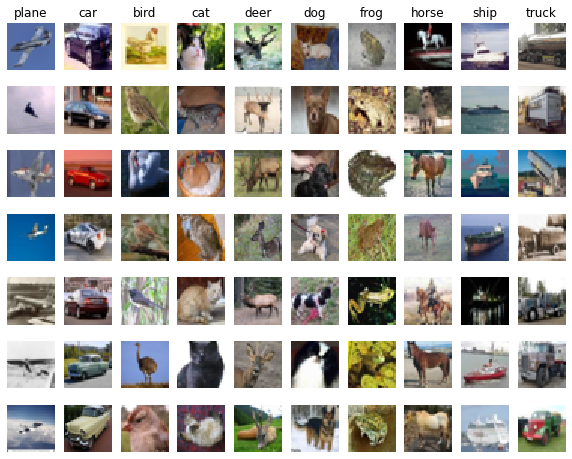

In [58]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [59]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [60]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


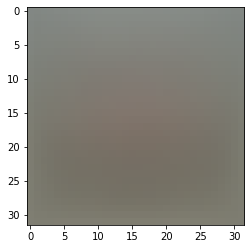

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [61]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [62]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.360906


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [63]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 18.028659 analytic: 18.028659, relative error: 2.034548e-11
numerical: -17.849212 analytic: -17.849212, relative error: 9.543886e-12
numerical: 23.526064 analytic: 23.526064, relative error: 1.966023e-12
numerical: 9.168581 analytic: 9.168581, relative error: 2.447180e-12
numerical: -21.076359 analytic: -21.076359, relative error: 2.707558e-12
numerical: -50.076395 analytic: -50.076395, relative error: 1.934126e-12
numerical: -26.696208 analytic: -26.696208, relative error: 7.508070e-12
numerical: -14.574329 analytic: -14.574329, relative error: 1.722292e-11
numerical: 9.647770 analytic: 9.647770, relative error: 3.336097e-11
numerical: -28.589076 analytic: -28.589076, relative error: 2.196404e-11
numerical: 13.315780 analytic: 13.315780, relative error: 2.012295e-11
numerical: 5.629611 analytic: 5.629611, relative error: 1.419827e-11
numerical: -1.448723 analytic: -1.448723, relative error: 1.577000e-10
numerical: 21.446756 analytic: 21.351779, relative error: 2.219181e-03


**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [64]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.360906e+00 computed in 0.075352s
Vectorized loss: 9.360906e+00 computed in 0.002410s
difference: -0.000000


In [53]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.068697s
Vectorized loss and gradient: computed in 0.002536s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [72]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 784.398019
iteration 100 / 1500: loss 284.924996
iteration 200 / 1500: loss 106.400113
iteration 300 / 1500: loss 42.168221
iteration 400 / 1500: loss 17.820115
iteration 500 / 1500: loss 9.546506
iteration 600 / 1500: loss 6.813940
iteration 700 / 1500: loss 4.932326
iteration 800 / 1500: loss 5.500793
iteration 900 / 1500: loss 5.183866
iteration 1000 / 1500: loss 4.543564
iteration 1100 / 1500: loss 4.687914
iteration 1200 / 1500: loss 4.389908
iteration 1300 / 1500: loss 4.735139
iteration 1400 / 1500: loss 4.890456
That took 4.620445s


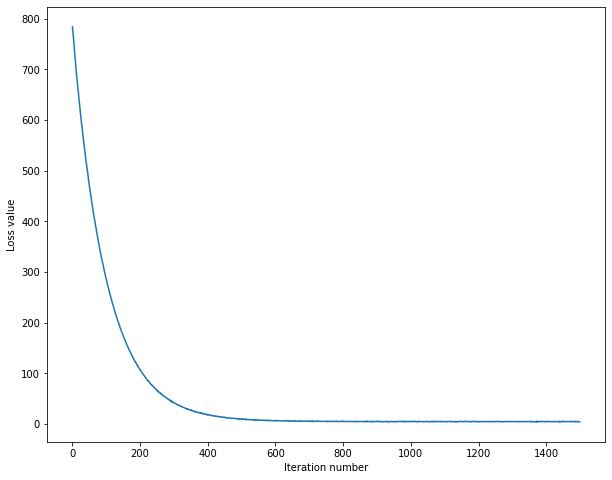

In [73]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [78]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.351184
validation accuracy: 0.365000


In [88]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for log_rate in np.linspace(-7,-5,21):
    rate = 10 ** log_rate
    for r in np.linspace(2.5,5,26):
        reg = r * 10 ** 4
        svm = LinearSVM()
        _ = svm.train(X_train, y_train, learning_rate=rate, reg=reg,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        accu_train = np.mean(y_train == y_train_pred)
        accu_val = np.mean(y_val == y_val_pred)
        results[(rate,reg)] = (accu_train,accu_val)
        if best_val < accu_val:
            best_val = accu_val
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 19.850599
iteration 100 / 1500: loss 9.582262
iteration 200 / 1500: loss 8.954361
iteration 300 / 1500: loss 6.784444
iteration 400 / 1500: loss 7.039330
iteration 500 / 1500: loss 6.778466
iteration 600 / 1500: loss 6.329306
iteration 700 / 1500: loss 6.245624
iteration 800 / 1500: loss 6.610697
iteration 900 / 1500: loss 5.532872
iteration 1000 / 1500: loss 7.219492
iteration 1100 / 1500: loss 5.074234
iteration 1200 / 1500: loss 4.679202
iteration 1300 / 1500: loss 4.894581
iteration 1400 / 1500: loss 5.034685
iteration 0 / 1500: loss 25.048197
iteration 100 / 1500: loss 10.211064
iteration 200 / 1500: loss 7.757215
iteration 300 / 1500: loss 7.813810
iteration 400 / 1500: loss 7.978220
iteration 500 / 1500: loss 6.353251
iteration 600 / 1500: loss 5.200329
iteration 700 / 1500: loss 5.327801
iteration 800 / 1500: loss 5.338780
iteration 900 / 1500: loss 5.513329
iteration 1000 / 1500: loss 5.234618
iteration 1100 / 1500: loss 4.671060
iteration 1200 / 1500:

iteration 100 / 1500: loss 10.551839
iteration 200 / 1500: loss 8.955993
iteration 300 / 1500: loss 7.372102
iteration 400 / 1500: loss 6.337670
iteration 500 / 1500: loss 8.486343
iteration 600 / 1500: loss 5.319172
iteration 700 / 1500: loss 5.904541
iteration 800 / 1500: loss 4.589885
iteration 900 / 1500: loss 5.508066
iteration 1000 / 1500: loss 6.096538
iteration 1100 / 1500: loss 5.080902
iteration 1200 / 1500: loss 4.310449
iteration 1300 / 1500: loss 5.123206
iteration 1400 / 1500: loss 4.949471
iteration 0 / 1500: loss 18.221767
iteration 100 / 1500: loss 10.415333
iteration 200 / 1500: loss 8.852133
iteration 300 / 1500: loss 8.077250
iteration 400 / 1500: loss 6.325726
iteration 500 / 1500: loss 6.538737
iteration 600 / 1500: loss 5.784422
iteration 700 / 1500: loss 4.888748
iteration 800 / 1500: loss 5.918155
iteration 900 / 1500: loss 5.442892
iteration 1000 / 1500: loss 5.249702
iteration 1100 / 1500: loss 4.771867
iteration 1200 / 1500: loss 4.271189
iteration 1300 / 15

iteration 200 / 1500: loss 7.748374
iteration 300 / 1500: loss 9.123690
iteration 400 / 1500: loss 7.968859
iteration 500 / 1500: loss 6.983483
iteration 600 / 1500: loss 6.168939
iteration 700 / 1500: loss 5.999008
iteration 800 / 1500: loss 5.864133
iteration 900 / 1500: loss 4.539972
iteration 1000 / 1500: loss 4.548840
iteration 1100 / 1500: loss 5.253151
iteration 1200 / 1500: loss 4.473646
iteration 1300 / 1500: loss 5.244417
iteration 1400 / 1500: loss 4.647367
iteration 0 / 1500: loss 21.534750
iteration 100 / 1500: loss 9.256671
iteration 200 / 1500: loss 9.356685
iteration 300 / 1500: loss 6.590225
iteration 400 / 1500: loss 6.771615
iteration 500 / 1500: loss 6.630357
iteration 600 / 1500: loss 5.759292
iteration 700 / 1500: loss 5.739663
iteration 800 / 1500: loss 5.801135
iteration 900 / 1500: loss 6.123249
iteration 1000 / 1500: loss 5.284008
iteration 1100 / 1500: loss 4.950650
iteration 1200 / 1500: loss 4.140106
iteration 1300 / 1500: loss 4.594539
iteration 1400 / 150

iteration 300 / 1500: loss 8.095499
iteration 400 / 1500: loss 6.724837
iteration 500 / 1500: loss 5.545624
iteration 600 / 1500: loss 5.867735
iteration 700 / 1500: loss 6.163648
iteration 800 / 1500: loss 6.157516
iteration 900 / 1500: loss 5.873165
iteration 1000 / 1500: loss 4.087167
iteration 1100 / 1500: loss 4.451059
iteration 1200 / 1500: loss 4.486816
iteration 1300 / 1500: loss 5.260105
iteration 1400 / 1500: loss 3.613119
iteration 0 / 1500: loss 20.677899
iteration 100 / 1500: loss 9.257042
iteration 200 / 1500: loss 6.915278
iteration 300 / 1500: loss 7.197471
iteration 400 / 1500: loss 6.212120
iteration 500 / 1500: loss 5.809312
iteration 600 / 1500: loss 5.374062
iteration 700 / 1500: loss 5.392467
iteration 800 / 1500: loss 6.118516
iteration 900 / 1500: loss 6.008093
iteration 1000 / 1500: loss 4.353256
iteration 1100 / 1500: loss 4.497899
iteration 1200 / 1500: loss 5.131930
iteration 1300 / 1500: loss 3.694086
iteration 1400 / 1500: loss 5.152785
iteration 0 / 1500:

iteration 400 / 1500: loss 7.189299
iteration 500 / 1500: loss 6.709372
iteration 600 / 1500: loss 5.905800
iteration 700 / 1500: loss 5.961946
iteration 800 / 1500: loss 4.973659
iteration 900 / 1500: loss 4.378476
iteration 1000 / 1500: loss 4.438796
iteration 1100 / 1500: loss 4.672410
iteration 1200 / 1500: loss 4.380629
iteration 1300 / 1500: loss 4.329741
iteration 1400 / 1500: loss 3.584906
iteration 0 / 1500: loss 23.558576
iteration 100 / 1500: loss 10.435416
iteration 200 / 1500: loss 7.826792
iteration 300 / 1500: loss 6.183693
iteration 400 / 1500: loss 5.805330
iteration 500 / 1500: loss 5.607197
iteration 600 / 1500: loss 6.226652
iteration 700 / 1500: loss 5.898742
iteration 800 / 1500: loss 5.213302
iteration 900 / 1500: loss 5.580329
iteration 1000 / 1500: loss 4.042728
iteration 1100 / 1500: loss 4.357803
iteration 1200 / 1500: loss 4.715310
iteration 1300 / 1500: loss 3.642915
iteration 1400 / 1500: loss 3.559814
iteration 0 / 1500: loss 27.116156
iteration 100 / 150

iteration 500 / 1500: loss 6.288862
iteration 600 / 1500: loss 5.157168
iteration 700 / 1500: loss 5.491608
iteration 800 / 1500: loss 4.546853
iteration 900 / 1500: loss 4.831034
iteration 1000 / 1500: loss 4.339928
iteration 1100 / 1500: loss 4.253637
iteration 1200 / 1500: loss 4.444003
iteration 1300 / 1500: loss 4.318934
iteration 1400 / 1500: loss 4.281913
iteration 0 / 1500: loss 22.228616
iteration 100 / 1500: loss 9.144508
iteration 200 / 1500: loss 7.849418
iteration 300 / 1500: loss 6.746553
iteration 400 / 1500: loss 6.022897
iteration 500 / 1500: loss 5.301439
iteration 600 / 1500: loss 5.353566
iteration 700 / 1500: loss 5.496397
iteration 800 / 1500: loss 5.575443
iteration 900 / 1500: loss 4.710603
iteration 1000 / 1500: loss 4.304656
iteration 1100 / 1500: loss 4.435623
iteration 1200 / 1500: loss 4.242434
iteration 1300 / 1500: loss 3.962994
iteration 1400 / 1500: loss 3.717884
iteration 0 / 1500: loss 23.730330
iteration 100 / 1500: loss 9.735918
iteration 200 / 1500

iteration 600 / 1500: loss 4.761711
iteration 700 / 1500: loss 4.557266
iteration 800 / 1500: loss 4.957193
iteration 900 / 1500: loss 4.492214
iteration 1000 / 1500: loss 3.902806
iteration 1100 / 1500: loss 3.916345
iteration 1200 / 1500: loss 3.954299
iteration 1300 / 1500: loss 4.135782
iteration 1400 / 1500: loss 4.219204
iteration 0 / 1500: loss 27.344174
iteration 100 / 1500: loss 8.319202
iteration 200 / 1500: loss 6.823143
iteration 300 / 1500: loss 6.937631
iteration 400 / 1500: loss 5.626218
iteration 500 / 1500: loss 5.474690
iteration 600 / 1500: loss 4.549199
iteration 700 / 1500: loss 4.234084
iteration 800 / 1500: loss 4.512179
iteration 900 / 1500: loss 5.190447
iteration 1000 / 1500: loss 3.949921
iteration 1100 / 1500: loss 3.905740
iteration 1200 / 1500: loss 3.365164
iteration 1300 / 1500: loss 3.663440
iteration 1400 / 1500: loss 3.686526
iteration 0 / 1500: loss 24.328632
iteration 100 / 1500: loss 8.834573
iteration 200 / 1500: loss 7.394587
iteration 300 / 1500

iteration 700 / 1500: loss 4.713716
iteration 800 / 1500: loss 4.846586
iteration 900 / 1500: loss 3.557574
iteration 1000 / 1500: loss 4.006143
iteration 1100 / 1500: loss 3.271821
iteration 1200 / 1500: loss 3.247541
iteration 1300 / 1500: loss 3.865492
iteration 1400 / 1500: loss 3.437618
iteration 0 / 1500: loss 21.440968
iteration 100 / 1500: loss 7.702023
iteration 200 / 1500: loss 6.145625
iteration 300 / 1500: loss 5.442022
iteration 400 / 1500: loss 4.632870
iteration 500 / 1500: loss 4.613415
iteration 600 / 1500: loss 4.427923
iteration 700 / 1500: loss 4.141468
iteration 800 / 1500: loss 4.135617
iteration 900 / 1500: loss 3.770264
iteration 1000 / 1500: loss 3.072898
iteration 1100 / 1500: loss 3.443500
iteration 1200 / 1500: loss 3.434860
iteration 1300 / 1500: loss 2.450152
iteration 1400 / 1500: loss 2.845058
iteration 0 / 1500: loss 24.199718
iteration 100 / 1500: loss 8.790681
iteration 200 / 1500: loss 6.378049
iteration 300 / 1500: loss 6.524744
iteration 400 / 1500

iteration 800 / 1500: loss 3.294296
iteration 900 / 1500: loss 3.399602
iteration 1000 / 1500: loss 3.332152
iteration 1100 / 1500: loss 3.327869
iteration 1200 / 1500: loss 3.086252
iteration 1300 / 1500: loss 3.495055
iteration 1400 / 1500: loss 3.678213
iteration 0 / 1500: loss 22.430128
iteration 100 / 1500: loss 8.601170
iteration 200 / 1500: loss 7.104056
iteration 300 / 1500: loss 6.478490
iteration 400 / 1500: loss 5.717754
iteration 500 / 1500: loss 5.246827
iteration 600 / 1500: loss 4.840115
iteration 700 / 1500: loss 4.739688
iteration 800 / 1500: loss 4.657176
iteration 900 / 1500: loss 4.403634
iteration 1000 / 1500: loss 3.667250
iteration 1100 / 1500: loss 3.911874
iteration 1200 / 1500: loss 3.415078
iteration 1300 / 1500: loss 3.086702
iteration 1400 / 1500: loss 2.549635
iteration 0 / 1500: loss 23.811575
iteration 100 / 1500: loss 8.768840
iteration 200 / 1500: loss 7.299945
iteration 300 / 1500: loss 5.741424
iteration 400 / 1500: loss 5.573195
iteration 500 / 1500

iteration 900 / 1500: loss 4.432152
iteration 1000 / 1500: loss 2.995809
iteration 1100 / 1500: loss 3.421934
iteration 1200 / 1500: loss 2.857786
iteration 1300 / 1500: loss 2.791046
iteration 1400 / 1500: loss 3.299808
iteration 0 / 1500: loss 21.012271
iteration 100 / 1500: loss 7.919922
iteration 200 / 1500: loss 5.685574
iteration 300 / 1500: loss 5.631335
iteration 400 / 1500: loss 5.043522
iteration 500 / 1500: loss 4.031284
iteration 600 / 1500: loss 4.320110
iteration 700 / 1500: loss 3.853782
iteration 800 / 1500: loss 4.263911
iteration 900 / 1500: loss 3.483505
iteration 1000 / 1500: loss 3.260703
iteration 1100 / 1500: loss 3.100698
iteration 1200 / 1500: loss 3.362624
iteration 1300 / 1500: loss 2.897832
iteration 1400 / 1500: loss 2.968963
iteration 0 / 1500: loss 22.473010
iteration 100 / 1500: loss 8.134389
iteration 200 / 1500: loss 6.491589
iteration 300 / 1500: loss 6.587157
iteration 400 / 1500: loss 5.880931
iteration 500 / 1500: loss 5.372445
iteration 600 / 1500

iteration 1000 / 1500: loss 3.671191
iteration 1100 / 1500: loss 3.216998
iteration 1200 / 1500: loss 2.421527
iteration 1300 / 1500: loss 3.153140
iteration 1400 / 1500: loss 3.284246
iteration 0 / 1500: loss 21.540295
iteration 100 / 1500: loss 8.676818
iteration 200 / 1500: loss 5.885356
iteration 300 / 1500: loss 6.071852
iteration 400 / 1500: loss 4.679429
iteration 500 / 1500: loss 4.624371
iteration 600 / 1500: loss 4.483708
iteration 700 / 1500: loss 4.478243
iteration 800 / 1500: loss 4.646412
iteration 900 / 1500: loss 3.091075
iteration 1000 / 1500: loss 3.562670
iteration 1100 / 1500: loss 3.408739
iteration 1200 / 1500: loss 2.976237
iteration 1300 / 1500: loss 3.263277
iteration 1400 / 1500: loss 2.774985
iteration 0 / 1500: loss 24.234808
iteration 100 / 1500: loss 6.858889
iteration 200 / 1500: loss 7.893561
iteration 300 / 1500: loss 6.613810
iteration 400 / 1500: loss 5.910573
iteration 500 / 1500: loss 5.579172
iteration 600 / 1500: loss 3.918653
iteration 700 / 1500

iteration 1100 / 1500: loss 2.726837
iteration 1200 / 1500: loss 2.956872
iteration 1300 / 1500: loss 2.485079
iteration 1400 / 1500: loss 2.507028
iteration 0 / 1500: loss 26.066059
iteration 100 / 1500: loss 7.760367
iteration 200 / 1500: loss 5.900554
iteration 300 / 1500: loss 5.264493
iteration 400 / 1500: loss 4.041070
iteration 500 / 1500: loss 4.888143
iteration 600 / 1500: loss 4.291553
iteration 700 / 1500: loss 3.726238
iteration 800 / 1500: loss 3.472284
iteration 900 / 1500: loss 3.071591
iteration 1000 / 1500: loss 3.221154
iteration 1100 / 1500: loss 2.997069
iteration 1200 / 1500: loss 2.875736
iteration 1300 / 1500: loss 2.418844
iteration 1400 / 1500: loss 2.787542
iteration 0 / 1500: loss 20.504401
iteration 100 / 1500: loss 7.744486
iteration 200 / 1500: loss 5.323408
iteration 300 / 1500: loss 6.238327
iteration 400 / 1500: loss 4.055191
iteration 500 / 1500: loss 4.633440
iteration 600 / 1500: loss 4.171354
iteration 700 / 1500: loss 3.484262
iteration 800 / 1500:

iteration 1200 / 1500: loss 2.700591
iteration 1300 / 1500: loss 3.265901
iteration 1400 / 1500: loss 2.786877
iteration 0 / 1500: loss 22.216208
iteration 100 / 1500: loss 8.715899
iteration 200 / 1500: loss 6.064831
iteration 300 / 1500: loss 5.196434
iteration 400 / 1500: loss 4.629609
iteration 500 / 1500: loss 4.855498
iteration 600 / 1500: loss 4.574805
iteration 700 / 1500: loss 3.814043
iteration 800 / 1500: loss 3.592274
iteration 900 / 1500: loss 3.729530
iteration 1000 / 1500: loss 3.604681
iteration 1100 / 1500: loss 3.072100
iteration 1200 / 1500: loss 2.948617
iteration 1300 / 1500: loss 2.572899
iteration 1400 / 1500: loss 2.661534
iteration 0 / 1500: loss 23.452168
iteration 100 / 1500: loss 7.187121
iteration 200 / 1500: loss 4.614483
iteration 300 / 1500: loss 4.532568
iteration 400 / 1500: loss 3.831410
iteration 500 / 1500: loss 3.500469
iteration 600 / 1500: loss 3.621125
iteration 700 / 1500: loss 3.396181
iteration 800 / 1500: loss 3.464400
iteration 900 / 1500: 

iteration 1300 / 1500: loss 2.093411
iteration 1400 / 1500: loss 2.075636
iteration 0 / 1500: loss 17.905988
iteration 100 / 1500: loss 6.658637
iteration 200 / 1500: loss 5.927919
iteration 300 / 1500: loss 5.158485
iteration 400 / 1500: loss 4.613895
iteration 500 / 1500: loss 3.312933
iteration 600 / 1500: loss 3.364992
iteration 700 / 1500: loss 3.351218
iteration 800 / 1500: loss 3.340721
iteration 900 / 1500: loss 2.717714
iteration 1000 / 1500: loss 2.835605
iteration 1100 / 1500: loss 2.495008
iteration 1200 / 1500: loss 2.502534
iteration 1300 / 1500: loss 2.937183
iteration 1400 / 1500: loss 2.199310
iteration 0 / 1500: loss 18.717232
iteration 100 / 1500: loss 6.387536
iteration 200 / 1500: loss 5.462258
iteration 300 / 1500: loss 5.078143
iteration 400 / 1500: loss 4.264389
iteration 500 / 1500: loss 4.740260
iteration 600 / 1500: loss 3.425774
iteration 700 / 1500: loss 3.561564
iteration 800 / 1500: loss 2.934028
iteration 900 / 1500: loss 2.745113
iteration 1000 / 1500: 

iteration 1400 / 1500: loss 2.303240
iteration 0 / 1500: loss 21.103538
iteration 100 / 1500: loss 7.247561
iteration 200 / 1500: loss 5.590426
iteration 300 / 1500: loss 4.474106
iteration 400 / 1500: loss 4.258029
iteration 500 / 1500: loss 3.382898
iteration 600 / 1500: loss 3.123846
iteration 700 / 1500: loss 2.619330
iteration 800 / 1500: loss 2.629467
iteration 900 / 1500: loss 2.722596
iteration 1000 / 1500: loss 2.932502
iteration 1100 / 1500: loss 2.431228
iteration 1200 / 1500: loss 2.164840
iteration 1300 / 1500: loss 1.967305
iteration 1400 / 1500: loss 1.921446
iteration 0 / 1500: loss 19.898349
iteration 100 / 1500: loss 6.108668
iteration 200 / 1500: loss 5.419050
iteration 300 / 1500: loss 4.148305
iteration 400 / 1500: loss 4.078606
iteration 500 / 1500: loss 3.411954
iteration 600 / 1500: loss 2.584325
iteration 700 / 1500: loss 2.801969
iteration 800 / 1500: loss 3.234350
iteration 900 / 1500: loss 3.012288
iteration 1000 / 1500: loss 2.410705
iteration 1100 / 1500: 

iteration 0 / 1500: loss 21.259080
iteration 100 / 1500: loss 5.617443
iteration 200 / 1500: loss 6.499494
iteration 300 / 1500: loss 4.658019
iteration 400 / 1500: loss 4.253212
iteration 500 / 1500: loss 3.575180
iteration 600 / 1500: loss 3.266911
iteration 700 / 1500: loss 2.906789
iteration 800 / 1500: loss 3.160302
iteration 900 / 1500: loss 2.805116
iteration 1000 / 1500: loss 2.258207
iteration 1100 / 1500: loss 2.414480
iteration 1200 / 1500: loss 2.421576
iteration 1300 / 1500: loss 2.335496
iteration 1400 / 1500: loss 1.851726
iteration 0 / 1500: loss 22.409097
iteration 100 / 1500: loss 7.378818
iteration 200 / 1500: loss 4.804979
iteration 300 / 1500: loss 4.156723
iteration 400 / 1500: loss 3.687077
iteration 500 / 1500: loss 3.449096
iteration 600 / 1500: loss 3.153359
iteration 700 / 1500: loss 2.771173
iteration 800 / 1500: loss 2.917213
iteration 900 / 1500: loss 2.468581
iteration 1000 / 1500: loss 2.406714
iteration 1100 / 1500: loss 3.107005
iteration 1200 / 1500: 

iteration 100 / 1500: loss 5.653901
iteration 200 / 1500: loss 4.783910
iteration 300 / 1500: loss 3.980634
iteration 400 / 1500: loss 3.436117
iteration 500 / 1500: loss 3.315547
iteration 600 / 1500: loss 2.861393
iteration 700 / 1500: loss 3.200219
iteration 800 / 1500: loss 2.076846
iteration 900 / 1500: loss 2.066720
iteration 1000 / 1500: loss 2.388449
iteration 1100 / 1500: loss 1.930984
iteration 1200 / 1500: loss 2.161873
iteration 1300 / 1500: loss 1.777714
iteration 1400 / 1500: loss 2.303824
iteration 0 / 1500: loss 25.816910
iteration 100 / 1500: loss 5.906209
iteration 200 / 1500: loss 4.796238
iteration 300 / 1500: loss 3.963040
iteration 400 / 1500: loss 3.645872
iteration 500 / 1500: loss 2.939190
iteration 600 / 1500: loss 2.645236
iteration 700 / 1500: loss 2.895292
iteration 800 / 1500: loss 3.025389
iteration 900 / 1500: loss 2.590631
iteration 1000 / 1500: loss 2.281331
iteration 1100 / 1500: loss 2.520541
iteration 1200 / 1500: loss 2.414252
iteration 1300 / 1500

iteration 200 / 1500: loss 4.626998
iteration 300 / 1500: loss 3.509321
iteration 400 / 1500: loss 3.343727
iteration 500 / 1500: loss 3.586431
iteration 600 / 1500: loss 3.953473
iteration 700 / 1500: loss 2.610239
iteration 800 / 1500: loss 2.486940
iteration 900 / 1500: loss 2.513030
iteration 1000 / 1500: loss 2.465964
iteration 1100 / 1500: loss 2.368512
iteration 1200 / 1500: loss 2.446310
iteration 1300 / 1500: loss 2.119235
iteration 1400 / 1500: loss 2.203993
iteration 0 / 1500: loss 21.290804
iteration 100 / 1500: loss 5.641944
iteration 200 / 1500: loss 5.139407
iteration 300 / 1500: loss 4.364887
iteration 400 / 1500: loss 3.933024
iteration 500 / 1500: loss 2.976764
iteration 600 / 1500: loss 3.554302
iteration 700 / 1500: loss 2.311305
iteration 800 / 1500: loss 2.763177
iteration 900 / 1500: loss 2.460974
iteration 1000 / 1500: loss 2.339858
iteration 1100 / 1500: loss 1.913092
iteration 1200 / 1500: loss 1.939834
iteration 1300 / 1500: loss 1.866130
iteration 1400 / 150

iteration 300 / 1500: loss 3.573987
iteration 400 / 1500: loss 3.752303
iteration 500 / 1500: loss 3.408859
iteration 600 / 1500: loss 2.558741
iteration 700 / 1500: loss 2.215082
iteration 800 / 1500: loss 2.564441
iteration 900 / 1500: loss 1.921431
iteration 1000 / 1500: loss 2.012408
iteration 1100 / 1500: loss 2.253277
iteration 1200 / 1500: loss 2.245672
iteration 1300 / 1500: loss 1.850047
iteration 1400 / 1500: loss 1.739323
iteration 0 / 1500: loss 22.473310
iteration 100 / 1500: loss 6.186315
iteration 200 / 1500: loss 4.880673
iteration 300 / 1500: loss 3.793502
iteration 400 / 1500: loss 3.236741
iteration 500 / 1500: loss 3.157767
iteration 600 / 1500: loss 2.767131
iteration 700 / 1500: loss 2.414669
iteration 800 / 1500: loss 2.976138
iteration 900 / 1500: loss 2.224857
iteration 1000 / 1500: loss 2.146620
iteration 1100 / 1500: loss 2.176900
iteration 1200 / 1500: loss 1.861558
iteration 1300 / 1500: loss 1.598347
iteration 1400 / 1500: loss 1.854726
iteration 0 / 1500:

iteration 400 / 1500: loss 3.592674
iteration 500 / 1500: loss 2.675232
iteration 600 / 1500: loss 2.716319
iteration 700 / 1500: loss 3.059144
iteration 800 / 1500: loss 2.253498
iteration 900 / 1500: loss 2.094764
iteration 1000 / 1500: loss 1.801313
iteration 1100 / 1500: loss 1.624567
iteration 1200 / 1500: loss 1.749944
iteration 1300 / 1500: loss 1.621734
iteration 1400 / 1500: loss 1.551879
iteration 0 / 1500: loss 26.379595
iteration 100 / 1500: loss 5.103344
iteration 200 / 1500: loss 3.885352
iteration 300 / 1500: loss 3.887851
iteration 400 / 1500: loss 3.275953
iteration 500 / 1500: loss 3.472617
iteration 600 / 1500: loss 2.231560
iteration 700 / 1500: loss 2.493607
iteration 800 / 1500: loss 2.278848
iteration 900 / 1500: loss 2.308939
iteration 1000 / 1500: loss 2.377440
iteration 1100 / 1500: loss 1.829626
iteration 1200 / 1500: loss 2.286934
iteration 1300 / 1500: loss 2.041647
iteration 1400 / 1500: loss 1.313983
iteration 0 / 1500: loss 20.595700
iteration 100 / 1500

iteration 500 / 1500: loss 3.413179
iteration 600 / 1500: loss 2.384692
iteration 700 / 1500: loss 2.508634
iteration 800 / 1500: loss 2.288920
iteration 900 / 1500: loss 1.923487
iteration 1000 / 1500: loss 2.052922
iteration 1100 / 1500: loss 2.168242
iteration 1200 / 1500: loss 1.755307
iteration 1300 / 1500: loss 2.842386
iteration 1400 / 1500: loss 1.506582
iteration 0 / 1500: loss 23.718674
iteration 100 / 1500: loss 5.745988
iteration 200 / 1500: loss 4.741763
iteration 300 / 1500: loss 3.209232
iteration 400 / 1500: loss 3.125530
iteration 500 / 1500: loss 2.650978
iteration 600 / 1500: loss 2.907761
iteration 700 / 1500: loss 2.403193
iteration 800 / 1500: loss 2.132008
iteration 900 / 1500: loss 1.932571
iteration 1000 / 1500: loss 2.086275
iteration 1100 / 1500: loss 1.769729
iteration 1200 / 1500: loss 1.846267
iteration 1300 / 1500: loss 1.862420
iteration 1400 / 1500: loss 2.002805
iteration 0 / 1500: loss 18.972071
iteration 100 / 1500: loss 6.158793
iteration 200 / 1500

iteration 600 / 1500: loss 2.563142
iteration 700 / 1500: loss 2.093672
iteration 800 / 1500: loss 2.508086
iteration 900 / 1500: loss 1.885698
iteration 1000 / 1500: loss 2.056847
iteration 1100 / 1500: loss 1.528481
iteration 1200 / 1500: loss 1.817481
iteration 1300 / 1500: loss 1.683449
iteration 1400 / 1500: loss 1.466063
iteration 0 / 1500: loss 20.154674
iteration 100 / 1500: loss 5.186800
iteration 200 / 1500: loss 3.964880
iteration 300 / 1500: loss 3.471026
iteration 400 / 1500: loss 2.655629
iteration 500 / 1500: loss 4.500517
iteration 600 / 1500: loss 2.662407
iteration 700 / 1500: loss 2.649479
iteration 800 / 1500: loss 2.447331
iteration 900 / 1500: loss 2.249657
iteration 1000 / 1500: loss 1.964319
iteration 1100 / 1500: loss 2.222082
iteration 1200 / 1500: loss 1.802405
iteration 1300 / 1500: loss 1.227010
iteration 1400 / 1500: loss 1.387371
iteration 0 / 1500: loss 22.377896
iteration 100 / 1500: loss 5.753761
iteration 200 / 1500: loss 4.063087
iteration 300 / 1500

iteration 700 / 1500: loss 2.521950
iteration 800 / 1500: loss 2.736027
iteration 900 / 1500: loss 1.627076
iteration 1000 / 1500: loss 1.772807
iteration 1100 / 1500: loss 1.934813
iteration 1200 / 1500: loss 1.835870
iteration 1300 / 1500: loss 2.140559
iteration 1400 / 1500: loss 1.599553
iteration 0 / 1500: loss 20.138815
iteration 100 / 1500: loss 6.683069
iteration 200 / 1500: loss 4.116083
iteration 300 / 1500: loss 3.509147
iteration 400 / 1500: loss 4.195056
iteration 500 / 1500: loss 2.496870
iteration 600 / 1500: loss 2.533453
iteration 700 / 1500: loss 2.323750
iteration 800 / 1500: loss 3.099257
iteration 900 / 1500: loss 2.637644
iteration 1000 / 1500: loss 1.865413
iteration 1100 / 1500: loss 1.820361
iteration 1200 / 1500: loss 1.602471
iteration 1300 / 1500: loss 1.637165
iteration 1400 / 1500: loss 1.722109
iteration 0 / 1500: loss 22.218795
iteration 100 / 1500: loss 6.961493
iteration 200 / 1500: loss 4.066163
iteration 300 / 1500: loss 3.512080
iteration 400 / 1500

iteration 800 / 1500: loss 2.285110
iteration 900 / 1500: loss 1.722484
iteration 1000 / 1500: loss 1.597506
iteration 1100 / 1500: loss 1.381017
iteration 1200 / 1500: loss 1.420177
iteration 1300 / 1500: loss 1.190496
iteration 1400 / 1500: loss 1.586385
iteration 0 / 1500: loss 22.039773
iteration 100 / 1500: loss 4.810775
iteration 200 / 1500: loss 4.185897
iteration 300 / 1500: loss 3.514670
iteration 400 / 1500: loss 2.991506
iteration 500 / 1500: loss 3.531013
iteration 600 / 1500: loss 2.499659
iteration 700 / 1500: loss 2.062413
iteration 800 / 1500: loss 2.427395
iteration 900 / 1500: loss 2.457587
iteration 1000 / 1500: loss 1.746327
iteration 1100 / 1500: loss 2.038054
iteration 1200 / 1500: loss 1.893893
iteration 1300 / 1500: loss 1.530258
iteration 1400 / 1500: loss 1.704620
iteration 0 / 1500: loss 23.575820
iteration 100 / 1500: loss 5.303621
iteration 200 / 1500: loss 3.944843
iteration 300 / 1500: loss 3.847982
iteration 400 / 1500: loss 3.287018
iteration 500 / 1500

iteration 900 / 1500: loss 2.123728
iteration 1000 / 1500: loss 2.031152
iteration 1100 / 1500: loss 1.825650
iteration 1200 / 1500: loss 1.637051
iteration 1300 / 1500: loss 2.918868
iteration 1400 / 1500: loss 1.617386
iteration 0 / 1500: loss 25.964721
iteration 100 / 1500: loss 5.055384
iteration 200 / 1500: loss 4.991626
iteration 300 / 1500: loss 3.650175
iteration 400 / 1500: loss 3.587839
iteration 500 / 1500: loss 2.456432
iteration 600 / 1500: loss 3.330329
iteration 700 / 1500: loss 2.044660
iteration 800 / 1500: loss 2.148297
iteration 900 / 1500: loss 3.030935
iteration 1000 / 1500: loss 1.845941
iteration 1100 / 1500: loss 2.083250
iteration 1200 / 1500: loss 1.982629
iteration 1300 / 1500: loss 1.438644
iteration 1400 / 1500: loss 1.516718
iteration 0 / 1500: loss 20.278577
iteration 100 / 1500: loss 6.439022
iteration 200 / 1500: loss 4.501868
iteration 300 / 1500: loss 4.073308
iteration 400 / 1500: loss 3.454605
iteration 500 / 1500: loss 1.939762
iteration 600 / 1500

iteration 1000 / 1500: loss 2.062585
iteration 1100 / 1500: loss 2.744108
iteration 1200 / 1500: loss 1.702391
iteration 1300 / 1500: loss 1.812232
iteration 1400 / 1500: loss 1.177602
iteration 0 / 1500: loss 23.192315
iteration 100 / 1500: loss 5.205739
iteration 200 / 1500: loss 5.541752
iteration 300 / 1500: loss 3.843152
iteration 400 / 1500: loss 2.747644
iteration 500 / 1500: loss 2.477284
iteration 600 / 1500: loss 2.766347
iteration 700 / 1500: loss 3.277170
iteration 800 / 1500: loss 2.830575
iteration 900 / 1500: loss 1.513504
iteration 1000 / 1500: loss 1.589225
iteration 1100 / 1500: loss 1.459339
iteration 1200 / 1500: loss 1.621961
iteration 1300 / 1500: loss 2.729387
iteration 1400 / 1500: loss 1.178366
iteration 0 / 1500: loss 25.081194
iteration 100 / 1500: loss 5.347514
iteration 200 / 1500: loss 3.830177
iteration 300 / 1500: loss 3.390867
iteration 400 / 1500: loss 3.000098
iteration 500 / 1500: loss 2.503117
iteration 600 / 1500: loss 2.720200
iteration 700 / 1500

iteration 1100 / 1500: loss 1.700459
iteration 1200 / 1500: loss 3.433758
iteration 1300 / 1500: loss 1.893228
iteration 1400 / 1500: loss 1.379834
iteration 0 / 1500: loss 24.523015
iteration 100 / 1500: loss 5.683755
iteration 200 / 1500: loss 4.283885
iteration 300 / 1500: loss 4.749189
iteration 400 / 1500: loss 4.068622
iteration 500 / 1500: loss 7.834452
iteration 600 / 1500: loss 2.746733
iteration 700 / 1500: loss 3.180405
iteration 800 / 1500: loss 2.479073
iteration 900 / 1500: loss 2.521013
iteration 1000 / 1500: loss 2.234910
iteration 1100 / 1500: loss 2.507255
iteration 1200 / 1500: loss 1.991502
iteration 1300 / 1500: loss 1.586316
iteration 1400 / 1500: loss 1.485539
iteration 0 / 1500: loss 23.704306
iteration 100 / 1500: loss 6.096727
iteration 200 / 1500: loss 4.151467
iteration 300 / 1500: loss 3.875456
iteration 400 / 1500: loss 6.650817
iteration 500 / 1500: loss 4.097744
iteration 600 / 1500: loss 3.078651
iteration 700 / 1500: loss 2.980472
iteration 800 / 1500:

iteration 1200 / 1500: loss 1.565376
iteration 1300 / 1500: loss 1.561305
iteration 1400 / 1500: loss 1.374945
iteration 0 / 1500: loss 21.421512
iteration 100 / 1500: loss 6.574851
iteration 200 / 1500: loss 5.870445
iteration 300 / 1500: loss 3.616162
iteration 400 / 1500: loss 3.516110
iteration 500 / 1500: loss 3.347665
iteration 600 / 1500: loss 2.571105
iteration 700 / 1500: loss 4.142519
iteration 800 / 1500: loss 3.408960
iteration 900 / 1500: loss 2.259701
iteration 1000 / 1500: loss 2.076182
iteration 1100 / 1500: loss 1.695493
iteration 1200 / 1500: loss 1.877146
iteration 1300 / 1500: loss 1.037480
iteration 1400 / 1500: loss 1.247752
iteration 0 / 1500: loss 21.251091
iteration 100 / 1500: loss 6.501847
iteration 200 / 1500: loss 4.787539
iteration 300 / 1500: loss 3.180772
iteration 400 / 1500: loss 3.857322
iteration 500 / 1500: loss 3.919075
iteration 600 / 1500: loss 3.885585
iteration 700 / 1500: loss 2.304211
iteration 800 / 1500: loss 2.349299
iteration 900 / 1500: 

iteration 1300 / 1500: loss 2.221119
iteration 1400 / 1500: loss 3.536351
iteration 0 / 1500: loss 22.363281
iteration 100 / 1500: loss 4.481208
iteration 200 / 1500: loss 7.939057
iteration 300 / 1500: loss 5.710111
iteration 400 / 1500: loss 3.093001
iteration 500 / 1500: loss 3.007003
iteration 600 / 1500: loss 2.459712
iteration 700 / 1500: loss 2.503481
iteration 800 / 1500: loss 2.475872
iteration 900 / 1500: loss 2.441380
iteration 1000 / 1500: loss 1.948590
iteration 1100 / 1500: loss 1.508785
iteration 1200 / 1500: loss 2.116337
iteration 1300 / 1500: loss 1.806360
iteration 1400 / 1500: loss 1.485001
iteration 0 / 1500: loss 22.426968
iteration 100 / 1500: loss 8.373226
iteration 200 / 1500: loss 5.087001
iteration 300 / 1500: loss 4.577568
iteration 400 / 1500: loss 4.476189
iteration 500 / 1500: loss 5.919274
iteration 600 / 1500: loss 2.956695
iteration 700 / 1500: loss 1.656930
iteration 800 / 1500: loss 2.404543
iteration 900 / 1500: loss 1.611477
iteration 1000 / 1500: 

iteration 1400 / 1500: loss 1.339421
iteration 0 / 1500: loss 19.677200
iteration 100 / 1500: loss 7.044775
iteration 200 / 1500: loss 3.478419
iteration 300 / 1500: loss 4.673183
iteration 400 / 1500: loss 4.576217
iteration 500 / 1500: loss 4.440158
iteration 600 / 1500: loss 3.038223
iteration 700 / 1500: loss 3.175823
iteration 800 / 1500: loss 2.704807
iteration 900 / 1500: loss 3.731100
iteration 1000 / 1500: loss 2.003555
iteration 1100 / 1500: loss 2.187449
iteration 1200 / 1500: loss 2.507098
iteration 1300 / 1500: loss 1.567098
iteration 1400 / 1500: loss 1.437832
iteration 0 / 1500: loss 29.713877
iteration 100 / 1500: loss 6.128397
iteration 200 / 1500: loss 5.442629
iteration 300 / 1500: loss 7.601496
iteration 400 / 1500: loss 3.390865
iteration 500 / 1500: loss 3.315400
iteration 600 / 1500: loss 3.897683
iteration 700 / 1500: loss 2.508708
iteration 800 / 1500: loss 1.831018
iteration 900 / 1500: loss 2.303489
iteration 1000 / 1500: loss 2.963981
iteration 1100 / 1500: 

iteration 0 / 1500: loss 24.011415
iteration 100 / 1500: loss 6.251544
iteration 200 / 1500: loss 5.713488
iteration 300 / 1500: loss 5.554646
iteration 400 / 1500: loss 6.155061
iteration 500 / 1500: loss 5.723542
iteration 600 / 1500: loss 4.369061
iteration 700 / 1500: loss 3.032736
iteration 800 / 1500: loss 6.482320
iteration 900 / 1500: loss 2.383071
iteration 1000 / 1500: loss 2.525032
iteration 1100 / 1500: loss 3.154983
iteration 1200 / 1500: loss 2.258197
iteration 1300 / 1500: loss 2.760972
iteration 1400 / 1500: loss 1.500998
iteration 0 / 1500: loss 20.544043
iteration 100 / 1500: loss 6.588965
iteration 200 / 1500: loss 6.161980
iteration 300 / 1500: loss 7.065375
iteration 400 / 1500: loss 4.250348
iteration 500 / 1500: loss 4.759890
iteration 600 / 1500: loss 10.206909
iteration 700 / 1500: loss 4.968838
iteration 800 / 1500: loss 2.247546
iteration 900 / 1500: loss 2.892088
iteration 1000 / 1500: loss 2.421653
iteration 1100 / 1500: loss 2.609647
iteration 1200 / 1500:

iteration 100 / 1500: loss 8.064955
iteration 200 / 1500: loss 5.333667
iteration 300 / 1500: loss 5.193329
iteration 400 / 1500: loss 3.994066
iteration 500 / 1500: loss 6.412659
iteration 600 / 1500: loss 4.112771
iteration 700 / 1500: loss 3.323144
iteration 800 / 1500: loss 2.907230
iteration 900 / 1500: loss 2.404599
iteration 1000 / 1500: loss 2.166257
iteration 1100 / 1500: loss 2.095245
iteration 1200 / 1500: loss 1.910407
iteration 1300 / 1500: loss 1.504042
iteration 1400 / 1500: loss 1.762078
iteration 0 / 1500: loss 21.810630
iteration 100 / 1500: loss 5.652851
iteration 200 / 1500: loss 7.822277
iteration 300 / 1500: loss 4.988455
iteration 400 / 1500: loss 5.880873
iteration 500 / 1500: loss 4.120106
iteration 600 / 1500: loss 3.518765
iteration 700 / 1500: loss 3.835908
iteration 800 / 1500: loss 2.353558
iteration 900 / 1500: loss 5.689394
iteration 1000 / 1500: loss 2.836814
iteration 1100 / 1500: loss 2.545601
iteration 1200 / 1500: loss 6.536123
iteration 1300 / 1500

iteration 200 / 1500: loss 7.993210
iteration 300 / 1500: loss 4.757318
iteration 400 / 1500: loss 3.055368
iteration 500 / 1500: loss 4.821325
iteration 600 / 1500: loss 3.884899
iteration 700 / 1500: loss 11.143920
iteration 800 / 1500: loss 5.695083
iteration 900 / 1500: loss 2.727000
iteration 1000 / 1500: loss 2.275400
iteration 1100 / 1500: loss 3.679923
iteration 1200 / 1500: loss 2.084166
iteration 1300 / 1500: loss 1.891200
iteration 1400 / 1500: loss 4.187827
iteration 0 / 1500: loss 26.531866
iteration 100 / 1500: loss 11.102704
iteration 200 / 1500: loss 4.638325
iteration 300 / 1500: loss 6.158450
iteration 400 / 1500: loss 5.426223
iteration 500 / 1500: loss 3.992687
iteration 600 / 1500: loss 3.708894
iteration 700 / 1500: loss 2.096843
iteration 800 / 1500: loss 2.859995
iteration 900 / 1500: loss 3.459518
iteration 1000 / 1500: loss 5.532246
iteration 1100 / 1500: loss 5.349610
iteration 1200 / 1500: loss 6.123574
iteration 1300 / 1500: loss 2.668998
iteration 1400 / 1

iteration 300 / 1500: loss 6.535768
iteration 400 / 1500: loss 7.184950
iteration 500 / 1500: loss 11.177851
iteration 600 / 1500: loss 8.027083
iteration 700 / 1500: loss 2.590945
iteration 800 / 1500: loss 2.222943
iteration 900 / 1500: loss 2.309626
iteration 1000 / 1500: loss 5.545263
iteration 1100 / 1500: loss 3.442898
iteration 1200 / 1500: loss 2.169923
iteration 1300 / 1500: loss 1.634813
iteration 1400 / 1500: loss 4.081957
iteration 0 / 1500: loss 22.162001
iteration 100 / 1500: loss 13.651574
iteration 200 / 1500: loss 5.339803
iteration 300 / 1500: loss 6.503242
iteration 400 / 1500: loss 4.647298
iteration 500 / 1500: loss 3.645633
iteration 600 / 1500: loss 3.819697
iteration 700 / 1500: loss 5.377852
iteration 800 / 1500: loss 6.698892
iteration 900 / 1500: loss 3.876771
iteration 1000 / 1500: loss 5.695260
iteration 1100 / 1500: loss 1.861646
iteration 1200 / 1500: loss 3.876062
iteration 1300 / 1500: loss 1.886918
iteration 1400 / 1500: loss 1.417850
iteration 0 / 150

iteration 400 / 1500: loss 4.909271
iteration 500 / 1500: loss 5.216651
iteration 600 / 1500: loss 7.861555
iteration 700 / 1500: loss 6.183226
iteration 800 / 1500: loss 4.033326
iteration 900 / 1500: loss 2.839903
iteration 1000 / 1500: loss 2.888093
iteration 1100 / 1500: loss 6.479390
iteration 1200 / 1500: loss 2.646243
iteration 1300 / 1500: loss 1.621772
iteration 1400 / 1500: loss 3.571597
iteration 0 / 1500: loss 20.270330
iteration 100 / 1500: loss 17.131405
iteration 200 / 1500: loss 6.358807
iteration 300 / 1500: loss 7.306670
iteration 400 / 1500: loss 6.101226
iteration 500 / 1500: loss 4.557460
iteration 600 / 1500: loss 3.461052
iteration 700 / 1500: loss 3.147763
iteration 800 / 1500: loss 3.285656
iteration 900 / 1500: loss 2.152883
iteration 1000 / 1500: loss 3.149284
iteration 1100 / 1500: loss 2.121509
iteration 1200 / 1500: loss 3.324383
iteration 1300 / 1500: loss 6.026282
iteration 1400 / 1500: loss 1.836124
iteration 0 / 1500: loss 23.651194
iteration 100 / 150

iteration 500 / 1500: loss 8.172436
iteration 600 / 1500: loss 6.639304
iteration 700 / 1500: loss 5.417103
iteration 800 / 1500: loss 4.034811
iteration 900 / 1500: loss 3.423348
iteration 1000 / 1500: loss 5.210905
iteration 1100 / 1500: loss 2.910142
iteration 1200 / 1500: loss 1.635749
iteration 1300 / 1500: loss 7.116877
iteration 1400 / 1500: loss 2.088313
iteration 0 / 1500: loss 19.033904
iteration 100 / 1500: loss 15.654204
iteration 200 / 1500: loss 14.545951
iteration 300 / 1500: loss 18.107424
iteration 400 / 1500: loss 5.563137
iteration 500 / 1500: loss 13.927920
iteration 600 / 1500: loss 6.288714
iteration 700 / 1500: loss 8.130604
iteration 800 / 1500: loss 5.492295
iteration 900 / 1500: loss 4.002307
iteration 1000 / 1500: loss 5.827815
iteration 1100 / 1500: loss 2.284303
iteration 1200 / 1500: loss 7.638436
iteration 1300 / 1500: loss 1.693407
iteration 1400 / 1500: loss 1.545724
iteration 0 / 1500: loss 27.334909
iteration 100 / 1500: loss 15.606292
iteration 200 /

iteration 500 / 1500: loss 5.697963
iteration 600 / 1500: loss 15.267675
iteration 700 / 1500: loss 10.000350
iteration 800 / 1500: loss 7.577779
iteration 900 / 1500: loss 5.316861
iteration 1000 / 1500: loss 2.841061
iteration 1100 / 1500: loss 3.163878
iteration 1200 / 1500: loss 2.466604
iteration 1300 / 1500: loss 2.642099
iteration 1400 / 1500: loss 4.975262
iteration 0 / 1500: loss 19.072217
iteration 100 / 1500: loss 11.069485
iteration 200 / 1500: loss 8.073800
iteration 300 / 1500: loss 11.007279
iteration 400 / 1500: loss 8.649252
iteration 500 / 1500: loss 5.482854
iteration 600 / 1500: loss 4.482519
iteration 700 / 1500: loss 6.859855
iteration 800 / 1500: loss 4.038515
iteration 900 / 1500: loss 6.849050
iteration 1000 / 1500: loss 3.700657
iteration 1100 / 1500: loss 4.713197
iteration 1200 / 1500: loss 4.710687
iteration 1300 / 1500: loss 3.115381
iteration 1400 / 1500: loss 1.927076
iteration 0 / 1500: loss 21.601084
iteration 100 / 1500: loss 17.669972
iteration 200 /

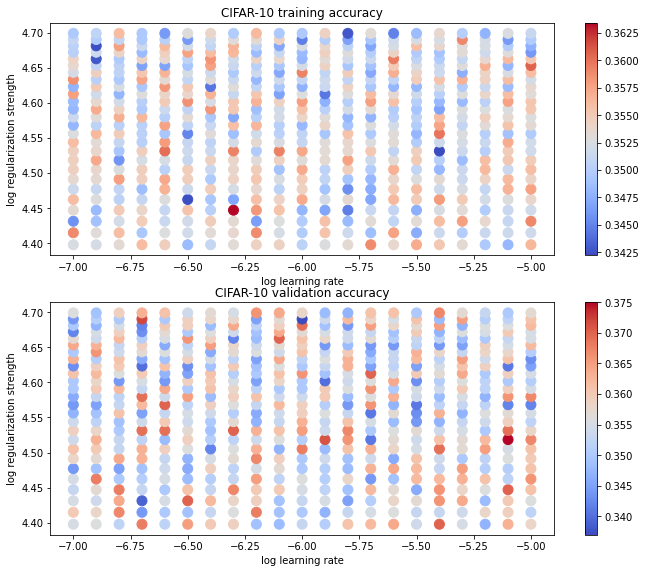

In [84]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [86]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.360000


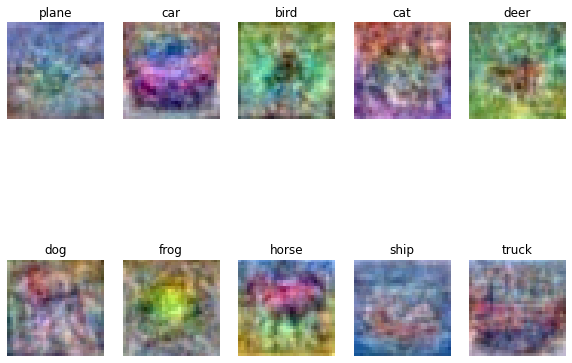

In [87]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
